# Code for the paper "A Fair Post-Processing Method based on the MADD Metric for Predictive Student Models"

Run once the following cell to change the notebook's kernel to the one associated to the virtual environment `env`, if it is not already the case.
Then, comment the cell, and run all cells.

In [1]:
# %%javascript
# Jupyter.notebook.session.restart({kernel_name: 'env'})

In [2]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

import distribution_tools as dt
import distribution_examples as de
import post_processing_tools as ppt
import MADD_tools as mt

In [ ]:
importlib.reload(dt)
importlib.reload(de)
importlib.reload(ppt)
importlib.reload(mt)

## Experiments on simulated data
### Prepare the simulation

In [4]:
n0 = 10000
n1 = 10000
my_nb_bins = np.floor(1/(0.1*mt.opt_bandwidth_order(n0, n1))).astype(int)
print("Number of bins: ", my_nb_bins)

Number of bins:  135


### Simulation 1

In [5]:
result1 = ppt.simulation(n0=n0, n1=n1, nb_bins=my_nb_bins, inv_cdf_0=de.inv_cdf_f8, inv_cdf_1=de.inv_cdf_f9, loss_type='accuracy_percentage', real_madd=True, auto_rescale=False, start_seed=1, seuil=0.5)

Calculating: 100%|███████████████████| 10000/10000 [08:33<00:00, 19.46it/s]


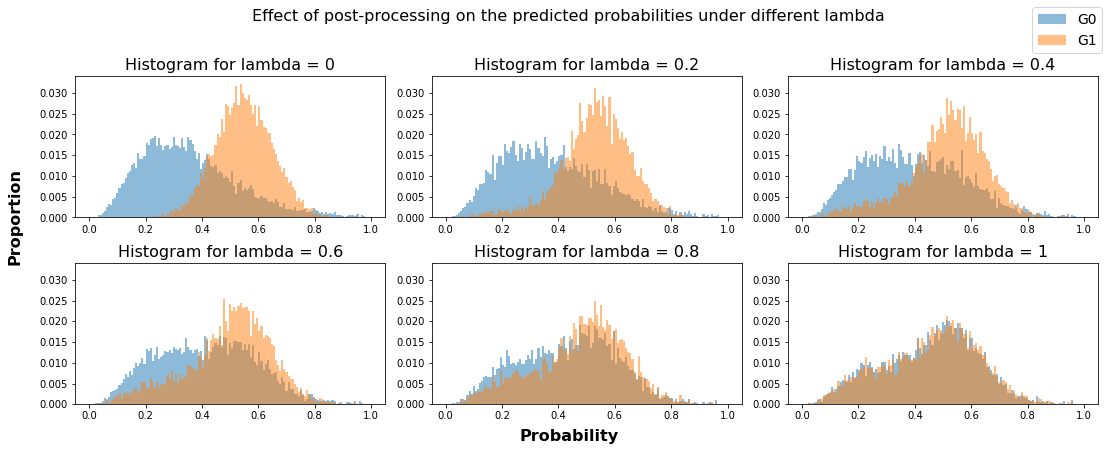

In [6]:
# Figure 5 : Effect of the MADD post-processing on the predicted probabilities with increasing values of λ

fig, axs = plt.subplots(2, 3, figsize=(15, 6))
lambdas = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Loop over each subplot and plot the data
for i in range(2):
    for j in range(3):
        y_pred_imporoved = ppt.fair_imporved_predicton(data=result1[3], lambda_=lambdas[i*3+j])
        new_Q0, new_Q1 = y_pred_imporoved[:n0], y_pred_imporoved[n0:]
        args0 = {'x': new_Q0, 'bins': my_nb_bins, 'range': (0, 1), 'alpha': 0.5, 'label': 'G0', 'weights': np.ones(n0) / n0}
        args1 = {'x': new_Q1, 'bins': my_nb_bins, 'range': (0, 1), 'alpha': 0.5, 'label': 'G1', 'weights': np.ones(n1) / n1}
        # Plot the data on subplot [i, j]
        axs[i, j].hist(**args0)
        axs[i, j].hist(**args1)
        axs[i, j].set_title('Histogram for lambda = ' + str(lambdas[i*3+j]), fontsize=16)
        axs[i, j].set_ylim([0, 0.034])

# Add a common x and y label outside the big picture
fig.text(0.5, -0.02, 'Probability', ha='center', fontsize=16, fontweight='bold')
fig.text(-0.02, 0.5, 'Proportion', va='center', rotation='vertical', fontsize=16, fontweight='bold')

fig.suptitle('Effect of post-processing on the predicted probabilities under different lambda', fontsize=16)
fig.legend(['G0', 'G1'], fontsize=14)
# Adjust the spacing between plots
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

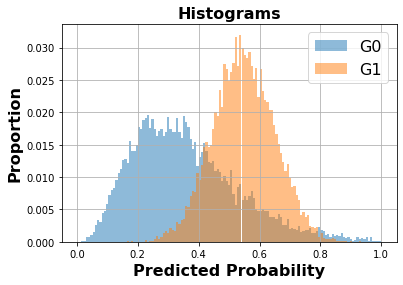

In [7]:
# Figure 6a
Q0, Q1, y_true = ppt.simulation_precomputed(n0, n1, inv_cdf_0=de.inv_cdf_f8, inv_cdf_1=de.inv_cdf_f9, loss_type='accuracy_percentage', start_seed=1, seuil=0.5)
dt.plot_2histograms(Q0=Q0, Q1=Q1, nb_bins=my_nb_bins, xlable_args={'fontsize':16}, ylabel_args={'fontsize':16}, title_args={'fontsize':16}, legend_args={'fontsize':16})

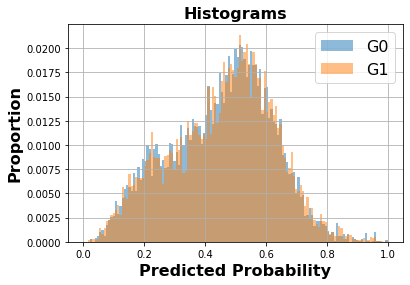

In [8]:
# Figure 6b
y_pred_imporoved = ppt.fair_imporved_predicton(data=result1[3], lambda_=1)
new_Q0, new_Q1 = y_pred_imporoved[:n0], y_pred_imporoved[n0:]
dt.plot_2histograms(Q0=new_Q0, Q1=new_Q1, nb_bins=my_nb_bins, xlable_args={'fontsize':16}, ylabel_args={'fontsize':16}, title_args={'fontsize':16}, legend_args={'fontsize':16})

Calculating: 100%|█████████████████████| 1000/1000 [00:54<00:00, 18.24it/s]


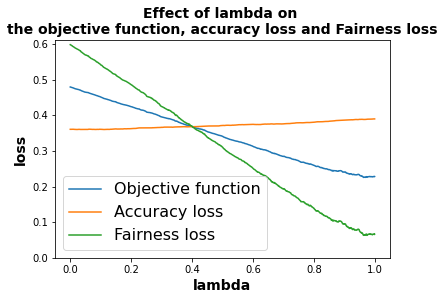

In [9]:
# Figure 6c
result2 = ppt.simulation_fixed_theta(n0=n0, n1=n1, nb_bins=my_nb_bins, theta = 0.5, inv_cdf_0=de.inv_cdf_f8, inv_cdf_1=de.inv_cdf_f9, loss_type='accuracy_percentage', real_madd=True, auto_rescale=False, start_seed=1, seuil=0.5)
ppt.plot_func_2D(Lambda = np.linspace(0, 1, 1000), total_loss=result2['total_loss'], accu_loss = result2['accu_loss'], madd=0.5*result2['madd'], ylim=[0, 0.61], legend_args={'fontsize':16}, title_args={'label': 'Effect of lambda on \nthe objective function, accuracy loss and Fairness loss'})

### Simulation 2 (additional)

Calculating: 100%|█████████████████████| 1000/1000 [00:54<00:00, 18.20it/s]


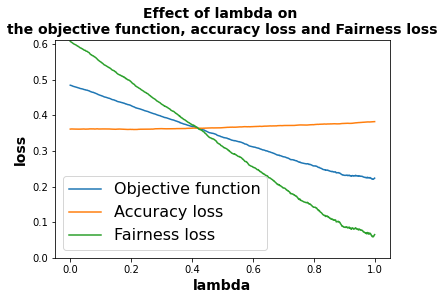

In [10]:
# Figure 6d
result3 = ppt.simulation_fixed_theta(n0=n0, n1=n1, nb_bins=my_nb_bins, theta = 0.5, inv_cdf_0=de.inv_cdf_f8, inv_cdf_1=de.inv_cdf_f9, loss_type='accuracy_percentage', real_madd=True, auto_rescale=False, start_seed=2, seuil=0.5)
ppt.plot_func_2D(Lambda = np.linspace(0, 1, 1000), total_loss=result3['total_loss'], accu_loss = result3['accu_loss'], madd=0.5*result3['madd'], ylim=[0, 0.61], legend_args={'fontsize':16}, title_args={'label': 'Effect of lambda on \nthe objective function, accuracy loss and Fairness loss'})

## Experiments on real data
### Prepare the data

In [11]:
# Preprocess the data
data_path2 = "data_kfold_100/"
MODELS2 = pickle.load(open(data_path2+"MODELS", "rb"))  # dict with names and trained models
models2 = MODELS2

SFEATURES2 = pickle.load(open(data_path2+"SFEATURES", "rb"))

DATA2 = pickle.load(open(data_path2+"DATA", "rb"))
SPLIT2 = pickle.load(open(data_path2+"SPLIT", "rb"))
FOLDS2 = pickle.load(open(data_path2+"FOLDS", "rb"))

# Load the sets
X_train = list()
X_test = list()
y_train = list()
y_test = list()

for i in range(0, FOLDS2):
    X_train.append( pd.read_csv(data_path2+"X_train" + "_" + DATA2 + "_K" + str(FOLDS2) + "_" + str(SPLIT2) + "%_" + str(i) + ".csv") )
    X_test.append( pd.read_csv(data_path2+"X_test" + "_" + DATA2 + "_K" + str(FOLDS2) + "_" + str(SPLIT2) + "%_" + str(i) + ".csv") )
    y_train.append( pd.read_csv(data_path2+"y_train" + "_" + DATA2 + "_K" + str(FOLDS2) + "_" + str(SPLIT2) + "%_" + str(i) + ".csv") )
    y_test.append( pd.read_csv(data_path2+"y_test" + "_" + DATA2 + "_K" + str(FOLDS2) + "_" + str(SPLIT2) + "%_" + str(i) + ".csv") )

In [12]:
split_index = np.arange(len(X_test[0]))
print(split_index)
np.random.seed(0)
np.random.shuffle(split_index)
print(split_index)
split_index = split_index[:int(len(split_index)*0.5)]
X_test_new = X_test[0].iloc[split_index]
y_test_new = y_test[0].iloc[split_index]
print(X_test_new.shape, y_test_new.shape)
X_val_new = X_test[0].drop(split_index)
y_val_new = y_test[0].drop(split_index)
print(X_val_new.shape, y_val_new.shape)

[   0    1    2 ... 1057 1058 1059]
[418 202 682 ... 835 559 684]
(530, 8) (530, 1)
(530, 8) (530, 1)


In [13]:
Q0_val = models2["clf_lr"][0].predict_proba(X_val_new[X_val_new["poverty"] == 0])[:,1]
Q1_val = models2["clf_lr"][0].predict_proba(X_val_new[X_val_new["poverty"] == 1])[:,1]
y_true_val = np.concatenate([y_val_new[X_val_new["poverty"] == 0], y_val_new[X_val_new["poverty"] == 1]])

n0_val = Q0_val.shape[0]
n1_val = Q1_val.shape[0]
print(n0_val, n1_val, n0_val/(n0_val+n1_val))
my_nb_bins = 40

217 313 0.40943396226415096


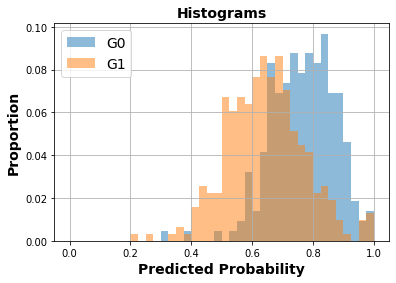

In [14]:
# Figure 7a
dt.plot_2histograms(Q0_val, Q1_val, nb_bins=my_nb_bins)

### Post-processing

Calculating: 100%|█████████████████████| 1000/1000 [00:13<00:00, 75.05it/s]


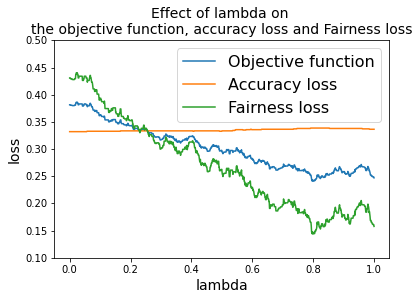

In [15]:
# Figure 7c
result_val_2 = ppt.post_processing_fixed_theta(Q0_val, Q1_val, y_true_val, nb_bins=my_nb_bins, theta=0.5, loss_type='accuracy_percentage', real_madd=True, auto_rescale=False, seuil=0.5)
ppt.plot_func_2D(Lambda = np.linspace(0, 1, 1000), total_loss=result_val_2['total_loss'], accu_loss = result_val_2['accu_loss'], madd=0.5*result_val_2['madd'], ylim=[0.1, 0.5], xlable_args={'fontweight':'normal'}, ylabel_args={'fontweight':'normal'}, title_args={'fontweight':'normal'}, legend_args={'fontsize':16})

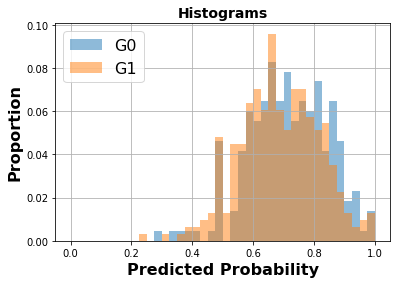

In [16]:
# Figure 7b
y_pred_imporoved = ppt.fair_imporved_predicton(data=result_val_2, lambda_=0.798)
new_Q0_val, new_Q1_val = y_pred_imporoved[:len(Q0_val)], y_pred_imporoved[len(Q0_val):]
dt.plot_2histograms(Q0=new_Q0_val, Q1=new_Q1_val, nb_bins=my_nb_bins, xlable_args={'fontsize':16}, ylabel_args={'fontsize':16}, legend_args={'fontsize':16, 'loc': 'upper left'})